# 1. Data Preparation

## 1a. Create a database for Images

### Why a database for images?
Instead of treating images as loose files in folders, we store them in a database so they become a structured, queryable dataset. This allows fast filtering by time and metadata, consistent preprocessing, reproducible experiments, and direct integration with embedding and search pipelines. The database provides indexing, versioning, and efficient storage of both image content and derived representations, turning the image collection into a reliable data asset rather than an unmanaged directory of files.

> **Note**  
> Before running this notebook, ensure you have the variable and limits determined. See notebook <>


### Imports

In [1]:
import json
from datetime import datetime, timezone
from pathlib import Path

import lancedb
import pyarrow as pa

# from helpers.ingest_images import ingest_images_to_table
from helpers.parallel_ingest_images import ingest_images_to_table

### User Input

In [2]:
PROJECT_ROOT = Path.cwd().parent.parent

IMG_RAW_TBL_NAME = "CLEVR_val_cropped"

db_dir = PROJECT_ROOT / "data" / "lancedb" / "shared_source"

image_dir = PROJECT_ROOT / "data" / "clevr_cropped_img"

RESOLUTION = 256

THUMB_RESOLUTION = 64

JPEG_QUALITY = 90

# Connect to DB
db = lancedb.connect(str(db_dir))

### Metadata 

In [3]:
# 1. Define the metadata structure

metadata_dict = {
    # --- 1. CORE IDENTITY ---
    "dataset_name": "CLEVR ",
    "description": "CLEVR validation dataset with a center crop",
    "author": "cherukuru",
    "generated_by_script": "imagemagick for cropping originals",
    "created_at": datetime.now(timezone.utc).isoformat(),  # Dynamic Timestamp
    # --- 2. SOURCE PROVENANCE (Sorted by Importance) ---
    "source_metadata": {
        "data_source": "CLEVR",
    },
    # --- 3. OUTPUT SPECIFICATIONS ---
    "image_specs": {
        "resolution": [RESOLUTION, RESOLUTION],
        "thumb_resolution": [THUMB_RESOLUTION, THUMB_RESOLUTION],
        "format": "JPEG",
        "quality": JPEG_QUALITY,
        "resampling": "Bilinear",
        "projection": "None",
    },
}

# 2. Serialize to JSON Bytes
arrow_metadata = {b"dataset_info": json.dumps(metadata_dict).encode("utf-8"), b"version": b"1.0"}

In [4]:
# Image table
schema = pa.schema(
    [
        pa.field("id", pa.string()),  # MD5 to generate a deterministic, content-based ID
        pa.field("filename", pa.string()),
        pa.field("image_blob", pa.binary()),
        pa.field("thumb_blob", pa.binary()),
    ],
    metadata=arrow_metadata,
)

if IMG_RAW_TBL_NAME in db.table_names():
    db.drop_table(IMG_RAW_TBL_NAME)

table = db.create_table(IMG_RAW_TBL_NAME, schema=schema)

print(f"Table {IMG_RAW_TBL_NAME} created.")

/glade/derecho/scratch/ncheruku/tmp/ipykernel_3500/4149338358.py:12: DeprecationWarning: table_names() is deprecated, use list_tables() instead
  if IMG_RAW_TBL_NAME in db.table_names():


Table CLEVR_val_cropped created.


In [5]:
# # Config Table (Global Metadata)

# config_data = [
#     {"key": "db_name",          "value": DB_NAME},
#     {"key": "created_at",       "value": datetime.now(UTC).strftime("%Y-%m-%dT%H:%M:%SZ")},
#     {"key": "author",           "value": "cherukuru"},
#     {"key": "project",          "value": "era5 data"},
#     {"key": "image_width",      "value": "224"},
#     {"key": "image_height",     "value": "224"},
#     {"key": "thumb_width",      "value": "64"},
#     {"key": "height",           "value": "64"},
#     {"key": "tbl_img_raw",      "value": IMG_RAW_TBL_NAME}
# ]

# # Create the config table
# # We use overwrite mode to ensure we don't have stale configs if re-running
# if METADATA_TBL_NAME in db.table_names():
#     db.drop_table(METADATA_TBL_NAME)

# # Note: We let LanceDB infer the simple schema (key: str, value: str) automatically
# # by passing the list of dicts directly.
# config_table = db.create_table(METADATA_TBL_NAME, data=config_data)
# print(f"Table {METADATA_TBL_NAME} created with global metadata.")

In [6]:
# ## Serial workflow
# ingest_images_to_table(
#     table,
#     image_dir=image_dir,
#     width=RESOLUTION,
#     height=RESOLUTION,
#     dt_format="%Y%m%d_rgb.jpeg",
#     thumb_size=THUMB_RESOLUTION,
#     batch_size=256
# )

In [7]:
# parallel workflow

ingest_images_to_table(
    table_obj=table,  # Open LanceDB table to write into
    image_dir=image_dir,  # Directory containing input images
    width=RESOLUTION,  # Stored image width
    height=RESOLUTION,  # Stored image height
    # dt_format="%Y%m%d_rgb.jpeg",  # Datetime pattern extracted from filename
    thumb_size=THUMB_RESOLUTION,  # Square thumbnail size in pixels
    batch_size=2048,  # Rows written to DB per transaction
    workers=31,  # Number of CPU processes for image processing
    max_in_flight=31 * 16,  # Max images allowed in RAM at once (memory safety)
)

Ingesting (parallel): 100%|██████████| 1628/1628 [00:18<00:00, 89.32it/s] 


Done.
Images ingested: 1628


1628

In [8]:
table.schema

id: string
filename: string
image_blob: binary
thumb_blob: binary
-- schema metadata --
dataset_info: '{"dataset_name": "CLEVR ", "description": "CLEVR validatio' + 363
version: '1.0'

In [9]:
json.loads(table.schema.metadata[b"dataset_info"])

{'dataset_name': 'CLEVR ',
 'description': 'CLEVR validation dataset with a center crop',
 'author': 'cherukuru',
 'generated_by_script': 'imagemagick for cropping originals',
 'created_at': '2026-02-20T01:43:19.648908+00:00',
 'source_metadata': {'data_source': 'CLEVR'},
 'image_specs': {'resolution': [256, 256],
  'thumb_resolution': [64, 64],
  'format': 'JPEG',
  'quality': 90,
  'resampling': 'Bilinear',
  'projection': 'None'}}

Filename: CLEVR_val_000013.png And ID: ad344749a4c556faab6779c7f2907476


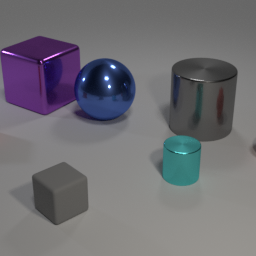

In [10]:
import io
import os

from PIL import Image

table.search().select(["id"]).limit(10).to_pandas()

row = table.search().limit(1000).to_pandas().iloc[10]
img = Image.open(io.BytesIO(row["image_blob"]))

print(f"Filename: {row["filename"]} And ID: {row["id"]}")
img

In [11]:
def dir_size_bytes(path: Path) -> int:
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            total += (Path(root) / f).stat().st_size
    return total


table_path = db_dir / f"{IMG_RAW_TBL_NAME}.lance"

# size_bytes = dir_size_bytes("/glade/work/ncheruku/research/bams-ai-data-exploration/data/lancedb/shared_source/era5/dinov3_image_embeddings.lance")

size_bytes = dir_size_bytes(table_path)


print(f"{size_bytes / 1024**2:.2f} MB")

94.12 MB
